# Search-Based Matching for structured references

Dominika Tkaczyk

5.05.2019

This notebook aims at selecting the best validation threshold value for the search-based matching algorithm for structured references.

## Methodology

The dataset is composed of 2,000 randomly chosen structured references. The best validation score value is the one maximizing reference-level F1.

## Results

In [1]:
import sys
sys.path.append('../..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.data_format_keys as dfk

from evaluation.link_metrics import LinkMetricsResults
from utils.utils import read_json
from utils.cr_utils import generate_unstructured

DATA_DIR = 'data/'

Read the validation datasets:

In [2]:
dataset_sbm = read_json(DATA_DIR + 'dataset_sbm.json')[dfk.DATASET_DATASET]
dataset_sbmv = read_json(DATA_DIR + 'dataset_sbmv.json')[dfk.DATASET_DATASET]
print('Dataset size: {}'.format(len(dataset_sbm)))

Dataset size: 2000


This function modifies the dataset according to the relevance or validation threshold:

In [3]:
def modify_validation_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_relevance_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(generate_unstructured(item[dfk.DATASET_REFERENCE])) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's calculate the results on the validation dataset for different thresholds:

In [4]:
results_sbm = [(t, LinkMetricsResults(modify_relevance_threshold(dataset_sbm, t)))
               for t in np.arange(0., 1., 0.01)]
results_sbmv = [(t, LinkMetricsResults(modify_validation_threshold(dataset_sbmv, t)))
               for t in np.arange(0., 1., .01)]

These functions plot the results for different thresholds and print the best values:

In [5]:
def plot_results(results):
    thresholds = [r[0] for r in results]
    results = [r[1] for r in results]
    plt.figure(figsize=(9,6))
    plt.rcParams.update({'font.size': 15})
    plt.plot(thresholds, [r.get(dfk.EVAL_PREC) for r in results], color='#3eb1c8')
    plt.plot(thresholds, [r.get(dfk.EVAL_REC) for r in results], color='#ffc72c')
    plt.plot(thresholds, [r.get(dfk.EVAL_F1) for r in results], color='#ef3340')
    plt.xticks(thresholds[0::10])
    plt.yticks([i / 10 for i in range(11)])
    plt.legend(['precision', 'recall', 'F1'], bbox_to_anchor=(0.82, 1.15), ncol=3)
    plt.xlabel('Relevance threshold')
    plt.ylabel('Metric value')
    plt.show()

def find_best(results):
    overall = [r[1].get(dfk.EVAL_F1) for r in results]
    index = len(overall) - overall[::-1].index(max(overall)) - 1
    return index, results[index][0], results[index][1].get(dfk.EVAL_PREC), \
        results[index][1].get(dfk.EVAL_REC), results[index][1].get(dfk.EVAL_F1)

def print_best(results):
    index, threshold, precision, recall, f1 = find_best(results)
    print('Maximum F1 ({:.4f}) is for threshold {}'.format(f1, threshold))
    print('Precision for this threshold: {:.4f}'.format(precision))
    print('Recall for this threshold: {:.4f}'.format(recall))

What are the best values for SBM?

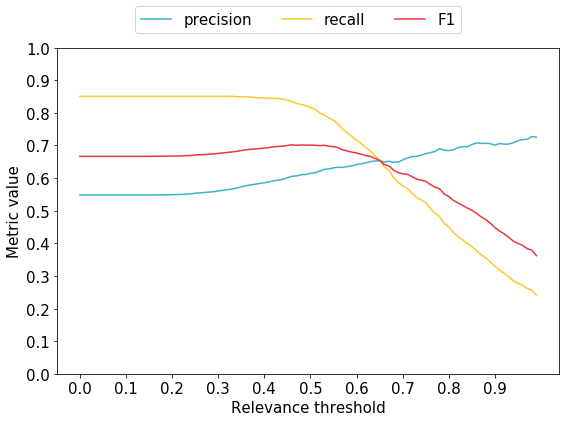

Maximum F1 (0.7021) is for threshold 0.46
Precision for this threshold: 0.6057
Recall for this threshold: 0.8352


In [6]:
plot_results(results_sbm)
print_best(results_sbm)

What are the best values for SBMV?

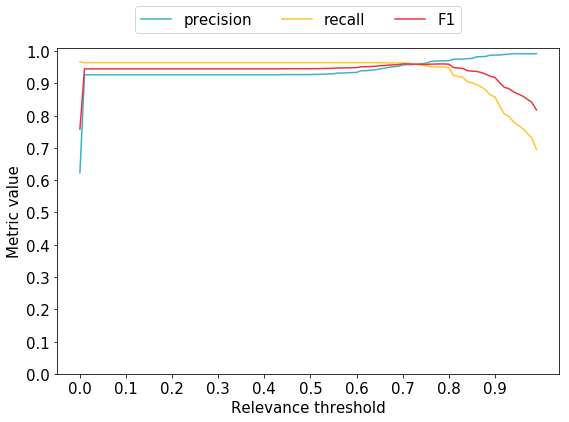

Maximum F1 (0.9602) is for threshold 0.71
Precision for this threshold: 0.9580
Recall for this threshold: 0.9625


In [7]:
plot_results(results_sbmv)
print_best(results_sbmv)

The best F1 is for threshold 0.71. However, precision for this threshold is quite small. Let's see a few higher values of the threshold:

In [8]:
results_sbmv_best = results_sbmv[65:85]
pd.DataFrame({'threshold': [r[0] for r in results_sbmv_best],
              'F1': [r[1].get(dfk.EVAL_F1) for r in results_sbmv_best],
              'precision': [r[1].get(dfk.EVAL_PREC) for r in results_sbmv_best],
              'recall': [r[1].get(dfk.EVAL_REC) for r in results_sbmv_best]})

,threshold,F1,precision,recall
0,0.65,0.954370,0.944870,0.964063
1,0.66,0.955108,0.946319,0.964063
2,0.67,0.956555,0.949923,0.963281
3,0.68,0.957298,0.951389,0.963281
4,0.69,0.958042,0.952859,0.963281
5,0.70,0.959907,0.956555,0.963281
6,0.71,0.960249,0.958009,0.962500
7,0.72,0.959438,0.957944,0.960938
8,0.73,0.959375,0.959375,0.959375
9,0.74,0.958904,0.960784,0.957031


Based on this, the value 0.78 seems better. The F1 is almost the same as for 0.71, but precision is higher.